Here the PFR1 Jacobien:

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from scipy.sparse import diags

# --- PFR Model ---
def PFR1(t, T, u, p):
    Nz = p["Nz"]
    dz = p["dz"]
    v = p["v"]
    DT = p["DT"]
    RT_fun = p.get("RT", lambda T: np.zeros_like(T))

    Tin_val = u if np.isscalar(u) else u(t)

    NT = np.zeros(Nz + 1)
    NT[0] = v * Tin_val
    for j in range(1, Nz):
        NT[j] = v * T[j - 1] - DT * (T[j] - T[j - 1]) / dz
    NT[Nz] = v * T[-1]

    dTdt = -(NT[1:] - NT[:-1]) / dz + RT_fun(T)
    return dTdt



#from scipy.sparse import lil_matrix
from scipy.sparse import lil_matrix



def PFR1_Jac(t, T, u, p):
    Nz = p["Nz"]
    dz = p["dz"]
    v = p["v"]
    DT = p["DT"]
    
    J = lil_matrix((Nz, Nz))

    for j in range(Nz):
        # Derivative of NT[j] terms:
        if j > 0:
            # NT[j]: depends on T[j-1] and T[j]
            J[j, j - 1] += (v + DT / dz) / dz     # ∂(-NT[j])/∂T[j-1]
            J[j, j]     += (-DT / dz) / dz        # ∂(-NT[j])/∂T[j]
        
        # Derivative of NT[j+1] terms:
        if j < Nz - 1:
            # NT[j+1]: depends on T[j] and T[j+1]
            J[j, j]     += -v / dz / dz           # ∂(NT[j+1])/∂T[j]
            J[j, j + 1] += (DT / dz) / dz         # ∂(NT[j+1])/∂T[j+1]

    return J.tocsr()

# --- Parameters ---
params = {
    "Nz": 50,
    "dz": 0.2,
    "v": 3.0,
    "DT": 0.1,
    "RT": lambda T: 0.0 * T  # No reaction term
}

T0 = np.ones(params["Nz"]) * 300.0  # Initial temperature
Tin = 350.0  # Inlet temperature

# --- Integrate using BDF with Jacobian ---
sol = solve_ivp(
    fun=lambda t, T: PFR1(t, T, Tin, params),
    jac=lambda t, T: PFR1_Jac(t, T, Tin, params),
    t_span=(0, 5),
    y0=T0,
    method='BDF',
    t_eval=np.linspace(0, 5, 100)
)

# --- Plot ---
z = np.linspace(0, params["Nz"] * params["dz"], params["Nz"])
time_indices = [0, 10, 30, 60, 99]

plt.figure(figsize=(8, 5))
for i in time_indices:
    plt.plot(z, sol.y[:, i], label=f't = {sol.t[i]:.1f} s')

plt.xlabel("Reactor Length z")
plt.ylabel("Temperature T")
plt.title("Temperature Profile in 1-State PFR Over Time")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

# Define the PFR 3-state model
def PFR_3state(t, C, Cin, p):
    CAin, CBin, Tin = Cin
    n, dz, v, F = p['Nz'], p['dz'], p['v'], p['F']
    k0, DA, DB, DT = np.exp(24.6), 0.1, 0.1, 0.1
    Ea_over_R = 8500

    CA, CB, T = C[:n], C[n:2*n], C[2*n:3*n]
    k = k0 * np.exp(-Ea_over_R / T)
    r = k * CA * CB

    def flux(C, D, Cin_):
        N = np.zeros(n+1)
        J = np.zeros(n+1)
        N[0] = F * Cin_
        N[1:] = F * C
        J[1:n] = (-D / dz) * (C[1:] - C[:-1])
        return N + J

    NA = flux(CA, DA, CAin)
    NB = flux(CB, DB, CBin)
    NT = flux(T, DT, Tin)

    RA = v[0] * r
    RB = v[1] * r
    RT = v[2] * r

    dCA = (NA[1:] - NA[:-1]) / -dz + RA
    dCB = (NB[1:] - NB[:-1]) / -dz + RB
    dT = (NT[1:] - NT[:-1]) / -dz + RT

    return np.concatenate([dCA, dCB, dT])

# Parameters
Nz = 100
L = 10
deltaHr = -560
rho = 1.0
cp = 4.186
beta = -deltaHr / (rho * cp)
v_vec = np.array([-1, -2, beta])
F = 50
dz = L / Nz
p = {'Nz': Nz, 'dz': dz, 'v': v_vec, 'F': F}
Cin = np.array([1.6, 2.4, 350])
CA0 = np.full(Nz, 0.1)
CB0 = np.full(Nz, 0.1)
T0 = np.full(Nz, 200)
C0 = np.concatenate([CA0, CB0, T0])

# Time settings
tspan = (0, 0.05)
t_eval = np.linspace(*tspan, 500)

# Solve
sol = solve_ivp(PFR_3state, tspan, C0, args=(Cin, p), t_eval=t_eval, method='BDF')

# Plotting CA, CB, T at selected times
fig, axs = plt.subplots(3, 1, figsize=(10, 10), sharex=True)
z = np.linspace(0, L, Nz)
time_indices = [0, 10, 30, 60, -1]

for i in time_indices:
    axs[0].plot(z, sol.y[0:Nz, i], label=f't={sol.t[i]:.3f}s')
    axs[1].plot(z, sol.y[Nz:2*Nz, i], label=f't={sol.t[i]:.3f}s')
    axs[2].plot(z, sol.y[2*Nz:3*Nz, i], label=f't={sol.t[i]:.3f}s')

axs[0].set_ylabel("CA")
axs[1].set_ylabel("CB")
axs[2].set_ylabel("T")
axs[2].set_xlabel("Reactor Length z")
for ax in axs:
    ax.legend()
    ax.grid(True)
fig.suptitle("PFR 3-State Model Over Time")
plt.tight_layout()
plt.show()


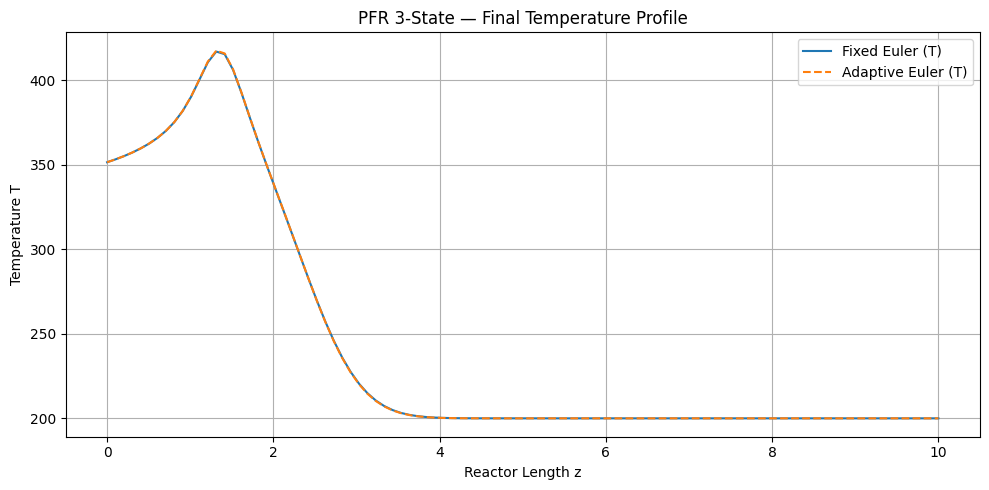

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

# --- PFR 3-State Function ---
def PFR_3state(t, C, Cin, p):
    CAin, CBin, Tin = Cin
    n, dz, v, F = p['Nz'], p['dz'], p['v'], p['F']
    k0, DA, DB, DT = np.exp(24.6), 0.1, 0.1, 0.1
    Ea_over_R = 8500

    CA, CB, T = C[:n], C[n:2*n], C[2*n:]
    k = k0 * np.exp(-Ea_over_R / T)
    r = k * CA * CB

    def flux(C, D, Cin_):
        N = np.zeros(n+1)
        J = np.zeros(n+1)
        N[0] = F * Cin_
        N[1:] = F * C
        J[1:n] = (-D / dz) * (C[1:] - C[:-1])
        return N + J

    NA = flux(CA, DA, CAin)
    NB = flux(CB, DB, CBin)
    NT = flux(T, DT, Tin)

    RA = v[0] * r
    RB = v[1] * r
    RT = v[2] * r

    dCA = (NA[1:] - NA[:-1]) / -dz + RA
    dCB = (NB[1:] - NB[:-1]) / -dz + RB
    dT = (NT[1:] - NT[:-1]) / -dz + RT

    return np.concatenate([dCA, dCB, dT])

# --- Explicit Euler Fixed Step ---
def explicit_euler_fixed(fun, t0, tf, N, x0, *args):
    dt = (tf - t0) / N
    T = np.linspace(t0, tf, N + 1)
    X = np.zeros((N + 1, len(x0)))
    X[0] = x0
    for k in range(N):
        X[k + 1] = X[k] + dt * fun(T[k], X[k], *args)
    return T, X

# --- Explicit Euler Adaptive Step ---
def explicit_euler_adaptive(fun, tspan, x0, h0, abstol, reltol, *args):
    epstol, facmin, facmax = 0.8, 0.1, 5.0
    t0, tf = tspan
    t, h = t0, h0
    x = np.array(x0, dtype=float)
    T, X = [t], [x.copy()]
    while t < tf:
        if t + h > tf:
            h = tf - t
        f = np.array(fun(t, x, *args))
        Accept = False
        while not Accept:
            x1 = x + h * f
            xm = x + 0.5 * h * f
            fm = np.array(fun(t + 0.5 * h, xm, *args))
            x1hat = xm + 0.5 * h * fm
            e = x1hat - x1
            denom = np.maximum(abstol, np.abs(x1hat) * reltol)
            r = np.max(np.abs(e) / denom)
            Accept = r <= epstol
            if Accept:
                t += h
                x = x1hat
                T.append(t)
                X.append(x.copy())
            h *= np.clip(np.sqrt(epstol / (r + 1e-12)), facmin, facmax)
    return np.array(T), np.array(X)

# --- Parameters ---
Nz = 100
L = 10
deltaHr = -560
rho = 1.0
cp = 4.186
beta = -deltaHr / (rho * cp)
v_vec = np.array([-1, -2, beta])
F = 50
dz = L / Nz
p = {'Nz': Nz, 'dz': dz, 'v': v_vec, 'F': F}
Cin = np.array([1.6, 2.4, 350])
CA0 = np.full(Nz, 0.1)
CB0 = np.full(Nz, 0.1)
T0 = np.full(Nz, 200)
C0 = np.concatenate([CA0, CB0, T0])

# --- Time settings ---
tspan = (0, 0.05)
N_steps = 500

# --- Solve ---
T_fixed, X_fixed = explicit_euler_fixed(PFR_3state, tspan[0], tspan[1], N_steps, C0, Cin, p)
T_adapt, X_adapt = explicit_euler_adaptive(PFR_3state, tspan, C0, 0.0001, 1e-6, 1e-3, Cin, p)

# --- Plot ---
z = np.linspace(0, L, Nz)
plt.figure(figsize=(10, 5))
plt.plot(z, X_fixed[-1, 2*Nz:], label='Fixed Euler (T)', lw=1.5)
plt.plot(z, X_adapt[-1, 2*Nz:], '--', label='Adaptive Euler (T)', lw=1.5)
plt.xlabel("Reactor Length z")
plt.ylabel("Temperature T")
plt.title("PFR 3-State — Final Temperature Profile")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

